# Section below imports packages and defines the connector

In [1]:
import requests,os,time
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from tqdm import tqdm_notebook as tqdm

In [2]:
### Define our Connector

def ratelimit(dt):
    "A function that handles the rate of your calls."
    time.sleep(dt) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=180,waiting_time=0.5):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    self.waiting_time = waiting_time # define simple rate_limit parameter.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit(self.waiting_time)
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit(self.waiting_time)
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id

# Define various variables, url, etc.

In [3]:
logfile = 'LOG_test_run.csv'

#For scrape of force names
forces_url = 'https://data.police.uk/api/forces'
forces_job_name = 'forces_job'

#For scrape of stop and searches data
scrape_base_url = 'https://data.police.uk/api/stops-force?force='
scrape_job_name = 'scrape_job'
date_from = '2019-01'
date_to = '2019-03'

#For save as csv
csv_name = 'DATA_test_run.csv'

# The scrape...

In [4]:
connector = Connector(logfile, overwrite_log=True)

In [5]:
#Extract police force data
response,call_id = connector.get(forces_url,forces_job_name)
Forces = pd.DataFrame(response.json())
Forces.head()

,id,name
0,avon-and-somerset,Avon and Somerset Constabulary
1,bedfordshire,Bedfordshire Police
2,cambridgeshire,Cambridgeshire Constabulary
3,cheshire,Cheshire Constabulary
4,city-of-london,City of London Police


In [6]:
len(Forces)

44

In [7]:
dates = pd.date_range(date_from,date_to , freq='1M')
dates = [d.strftime('%Y-%m') for d in dates]
List = []

for j in tqdm(Forces.id):
    for i in tqdm(dates):
        get_url = scrape_base_url + j +'&date='+i
        response,call_id = connector.get(get_url,scrape_job_name)
        response.text
        jason = response.json()
        data = pd.DataFrame(jason)
        data['Force'] = j
        List.append(data)

In [8]:
Data = pd.concat(List, sort=False)
Data.reset_index(drop=True)

,age_range,datetime,gender,involved_person,legislation,location,object_of_search,officer_defined_ethnicity,operation,operation_name,outcome,outcome_linked_to_object_of_search,outcome_object,removal_of_more_than_outer_clothing,self_defined_ethnicity,type,Force
0,18-24,2018-07-24T15:00:00+00:00,Male,True,Misuse of Drugs Act 1971 (section 23),"{'latitude': '51.338544', 'street': {'id': 537...",Controlled drugs,None,None,None,Arrest,True,"{'id': 'bu-arrest', 'name': 'Arrest'}",False,None,Person search,avon-and-somerset
1,None,2018-07-22T00:00:00+00:00,None,False,None,None,None,None,None,None,,None,"{'id': '', 'name': ''}",None,None,Vehicle search,avon-and-somerset
2,None,2018-07-15T16:00:00+00:00,None,False,Misuse of Drugs Act 1971 (section 23),"{'latitude': '51.408191', 'street': {'id': 539...",Controlled drugs,None,None,None,,True,"{'id': '', 'name': ''}",None,None,Vehicle search,avon-and-somerset
3,None,2018-07-30T00:00:00+00:00,None,False,None,None,None,None,None,None,,None,"{'id': '', 'name': ''}",None,None,Vehicle search,avon-and-somerset
4,over 34,2018-07-26T08:45:00+00:00,Male,True,Police and Criminal Evidence Act 1984 (section 1),None,Offensive weapons,White,None,None,Arrest,None,"{'id': 'bu-arrest', 'name': 'Arrest'}",False,White - Gypsy or Irish Traveller,Person search,avon-and-somerset
5,10-17,2018-07-21T19:22:00+00:00,Male,True,Police and Criminal Evidence Act 1984 (section 1),"{'latitude': '51.210354', 'street': {'id': 533...",Offensive weapons,White,None,None,A no further action disposal,None,"{'id': 'bu-no-further-action', 'name': 'A no f...",False,White - English/Welsh/Scottish/Northern Irish/...,Person search,avon-and-somerset
6,None,2018-07-16T17:15:00+00:00,Female,True,Police and Criminal Evidence Act 1984 (section 1),"{'latitude': '51.525158', 'street': {'id': 526...",Stolen goods,None,None,None,A no further action disposal,None,"{'id': 'bu-no-further-action', 'name': 'A no f...",False,None,Person search,avon-and-somerset
7,18-24,2018-07-16T17:15:00+00:00,Female,True,Police and Criminal Evidence Act 1984 (section 1),"{'latitude': '51.525158', 'street': {'id': 526...",Stolen goods,None,None,None,A no further action disposal,None,"{'id': 'bu-no-further-action', 'name': 'A no f...",False,None,Person search,avon-and-somerset
8,25-34,2018-07-07T00:15:00+00:00,Male,True,Misuse of Drugs Act 1971 (section 23),"{'latitude': '51.350977', 'street': {'id': 537...",Controlled drugs,White,None,None,A no further action disposal,None,"{'id': 'bu-no-further-action', 'name': 'A no f...",False,White - English/Welsh/Scottish/Northern Irish/...,Person search,avon-and-somerset
9,18-24,2018-07-16T17:15:00+00:00,Female,True,Police and Criminal Evidence Act 1984 (section 1),"{'latitude': '51.525158', 'street': {'id': 526...",Stolen goods,None,None,None,A no further action disposal,None,"{'id': 'bu-no-further-action', 'name': 'A no f...",False,None,Person search,avon-and-somerset


In [9]:
Data.to_csv(csv_name, index=False)

In [10]:
# Load the LOG
log_df = pd.read_csv(logfile,sep=';') # load the ;-separated log 

In [11]:
log_df.head(5)

,id,project,connector_type,t,delta_t,url,redirect_url,response_size,response_code,success,error
0,0,forces_job,requests,1.566474e+09,-1.217520,https://data.police.uk/api/forces,https://data.police.uk/api/forces,2258,200,True,NaN
1,1,scrape_job,requests,1.566474e+09,-1.422056,https://data.police.uk/api/stops-force?force=a...,https://data.police.uk/api/stops-force?force=a...,338237,200,True,NaN
2,2,scrape_job,requests,1.566474e+09,-1.202785,https://data.police.uk/api/stops-force?force=a...,https://data.police.uk/api/stops-force?force=a...,346608,200,True,NaN
3,3,scrape_job,requests,1.566474e+09,-0.762239,https://data.police.uk/api/stops-force?force=b...,https://data.police.uk/api/stops-force?force=b...,132494,200,True,NaN
4,4,scrape_job,requests,1.566474e+09,-0.519578,https://data.police.uk/api/stops-force?force=b...,https://data.police.uk/api/stops-force?force=b...,145725,200,True,NaN


In [12]:
# Convert the time column 't' to datetime 
#log_df['dt'] = log_df.t.apply(datetime.datetime.fromtimestamp)
log_df['dt'] = pd.to_datetime(log_df.t,unit='s')

In [13]:
dt = log_df.dt.values[0]

C:\Users\Troel\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Scraping progress')

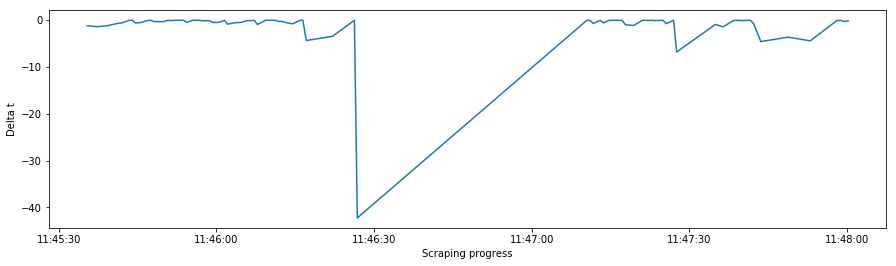

In [14]:
# Plot the time it took to make the call
plt.figure(figsize=(15,4))
plt.plot(log_df.dt,log_df.delta_t)
plt.ylabel('Delta t')
plt.xlabel('Scraping progress')


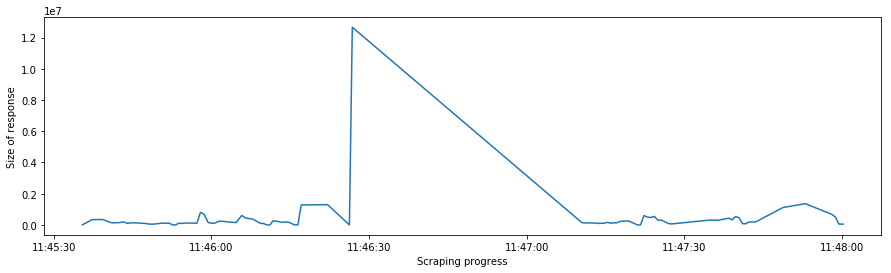

In [15]:
# Plot the response size over time.
plt.figure(figsize=(15,4))
plt.ylabel('Size of response')
plt.xlabel('Scraping progress')
plt.plot(log_df.dt,log_df.response_size)

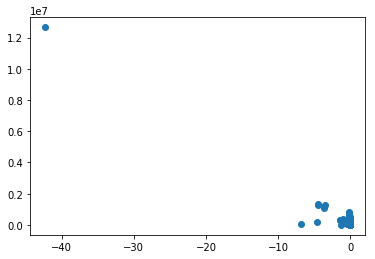

In [16]:
# Plot the delta_t against the response_size. These two should correlate pretty well.
plt.scatter(log_df.delta_t,log_df.response_size)

In [17]:
## Investigate errors
log_df.success.value_counts() ## Count errors
## Groupby time
# round the time for aggregation
log_df['dt_minute'] = log_df.dt.apply(lambda x: x-datetime.timedelta(seconds=x.second,microseconds=x.microsecond))
log_df['dt_hour'] = log_df.dt.apply(lambda x: x-datetime.timedelta(minutes=x.minute,seconds=x.second,microseconds=x.microsecond))
log_df.groupby('dt_hour').success.mean()

dt_hour
2019-08-22 11:00:00.000000001    True
2019-08-22 11:00:00.000000014    True
2019-08-22 11:00:00.000000023    True
2019-08-22 11:00:00.000000024    True
2019-08-22 11:00:00.000000038    True
2019-08-22 11:00:00.000000049    True
2019-08-22 11:00:00.000000063    True
2019-08-22 11:00:00.000000072    True
2019-08-22 11:00:00.000000083    True
2019-08-22 11:00:00.000000087    True
2019-08-22 11:00:00.000000100    True
2019-08-22 11:00:00.000000105    True
2019-08-22 11:00:00.000000143    True
2019-08-22 11:00:00.000000150    True
2019-08-22 11:00:00.000000159    True
2019-08-22 11:00:00.000000162    True
2019-08-22 11:00:00.000000194    True
2019-08-22 11:00:00.000000221    True
2019-08-22 11:00:00.000000224    True
2019-08-22 11:00:00.000000229    True
2019-08-22 11:00:00.000000264    True
2019-08-22 11:00:00.000000280    True
2019-08-22 11:00:00.000000283    True
2019-08-22 11:00:00.000000302    True
2019-08-22 11:00:00.000000303    True
2019-08-22 11:00:00.000000342    True
2019